<a href="https://colab.research.google.com/github/MoHazem02/ReLU-vs-Tanh-Activation-Function-Benchmark-in-BreakHis-Dataset/blob/main/Breast_Cancer_Cell_Classification_from_Microscopic_Images_(BreakHis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle tensorflow matplotlib scikit-learn h5py albumentations

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download (example for BreakHis or other Kaggle dataset)
!kaggle datasets download -d ambarish/breakhis
!mkdir -p /content/data/breakhis
!unzip -q breakhis.zip -d /content/data/breakhis

Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown
breakhis.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/data/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/README_B.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/data/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png? [y]es

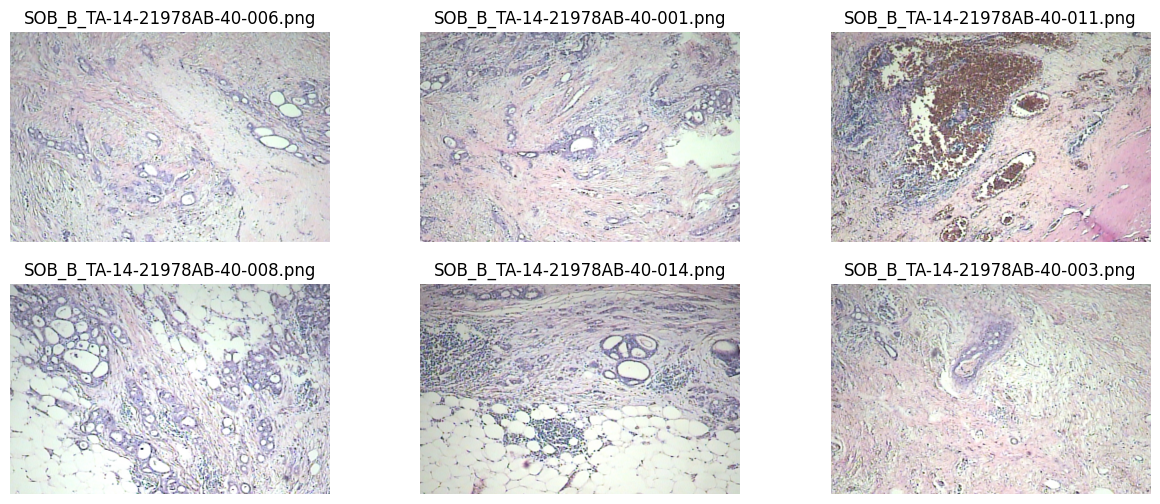

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
p = Path("/content/data/breakhis")
samples = list(p.glob("**/*.png")) # searches all files and looks for PNGs and puts the results in a list and gets first 6 images
images = samples[:6]
fig, axs = plt.subplots(2, 3, figsize=(15, 6))
for ax, sp in zip(axs.ravel(), samples): # axis.ravel() flattens a multi-dimensional array into a 1-dimensional array. Then zip() pairs up sample with an figure
  ax.imshow(Image.open(sp))
  ax.set_title(sp.name)
  ax.axis("off")
plt.show()

# Now that I see the data, My model will classify whether the tumor is Benign or Malignant using a **Deep Neural Network**

I will create `x_train, x_test, y_train, y_test` where Xi will be the name of the image and Yi will be B or M (B = 0 and M = 1) which can be known from Xi[4]

In [2]:
raw_image_names = [str(s).split('_') for s in samples]
print(raw_image_names[0])

['/content/data/breakhis/BreaKHis', 'v1/BreaKHis', 'v1/histology', 'slides/breast/benign/SOB/tubular', 'adenoma/SOB', 'B', 'TA', '14-21978AB/40X/SOB', 'B', 'TA-14-21978AB-40-006.png']


In [3]:
X = samples # X should be the list of all image paths
Y = [1 if name[5] == 'M' else 0 for name in raw_image_names] # Y should be the label (B or M) from the split path name
print(X[0])
print(Y[0])

/content/data/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma/SOB_B_TA_14-21978AB/40X/SOB_B_TA-14-21978AB-40-006.png
0


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)
# Notice here stratify = Y tells the code to maintain the X:Y ratio as it is in the original dataset
# For Ex: if M:B was 5:1 in original X:Y then I want the same ratio M:B to be 5:1 in Train:Test

In [5]:
import cv2
import numpy as np
from tqdm import tqdm

IMG_SIZE = 96 # I will resize each image to be 96x96

def preprocess_images(image_paths):
  images = []
  for path in tqdm(image_paths, desc="Loading and preprocessing images"):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # resize images to unified size
    img = img.astype('float32') / 255.0 # I will normalize the pixels to be [0,1]
    images.append(img)

  return np.stack(images, axis=0)

In [6]:
x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

print(x_train.shape)
print(x_test.shape)

Loading and preprocessing images: 100%|██████████| 1582/1582 [00:21<00:00, 73.66it/s]

(6327, 96, 96, 3)
(1582, 96, 96, 3)


In [7]:
y_train = np.array(y_train, dtype = np.float32) # TensorFlow expect all inputs and outputs to be of type float32 despite Y will be 0/1
y_test = np.array(y_test, dtype = np.float32)

print(y_train.shape)
print(y_test.shape)

(6327,)
(1582,)


Train set: (6327, 96, 96, 3) (6327,)
Test set: (1582, 96, 96, 3) (1582,)
Label distribution: (array([0., 1.], dtype=float32), array([1984, 4343]))


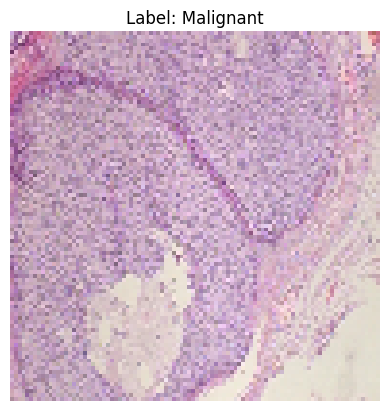

In [8]:
# Sanity Check
print("Train set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)
print("Label distribution:", np.unique(y_train, return_counts=True))

plt.imshow(x_train[0])
plt.title(f"Label: {'Malignant' if y_train[0]==1 else 'Benign'}")
plt.axis('off')
plt.show()


In [9]:
import tensorflow as tf

# I will build 2 models one using RELU and one using tanh but the output layer will be sigmoid in both. Instead of code redunducy I will write a helper function

def build_CNN(activation = 'relu'):

  """
  Builds a simple CNN for classifying BreakHis images as benign/malignant.

  Args:
      activation (str): Activation function for the hidden layers ('relu' or 'tanh').

  Returns:
      model (tf.keras.Model): Compiled CNN model.
    """
  model = tf.keras.Sequential([
      # Input Layer
      tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

      # Convolutional Block 1
      tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=activation, name='CNN_Layer_1'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Convolutional Block 2
      tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=activation, name='CNN_Layer_2'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Convolutional Block 3
      tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation=activation, name='CNN_Layer_3'),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Flatten + Dense layers
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation=activation, name='Dense_Layer_1'),
      tf.keras.layers.Dense(64, activation=activation, name='Dense_Layer_2'),

      # Output Block 4
      tf.keras.layers.Dense(1, activation='sigmoid', name='Output_Layer')

    ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='binary_crossentropy',
      metrics=['accuracy']
  )

  return model

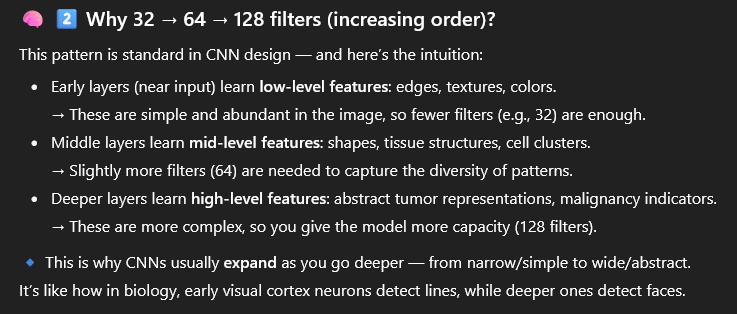

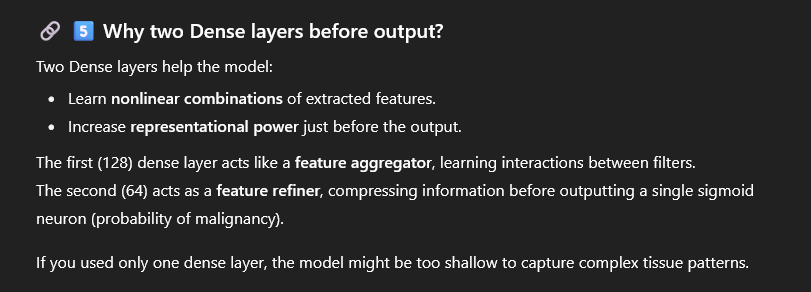

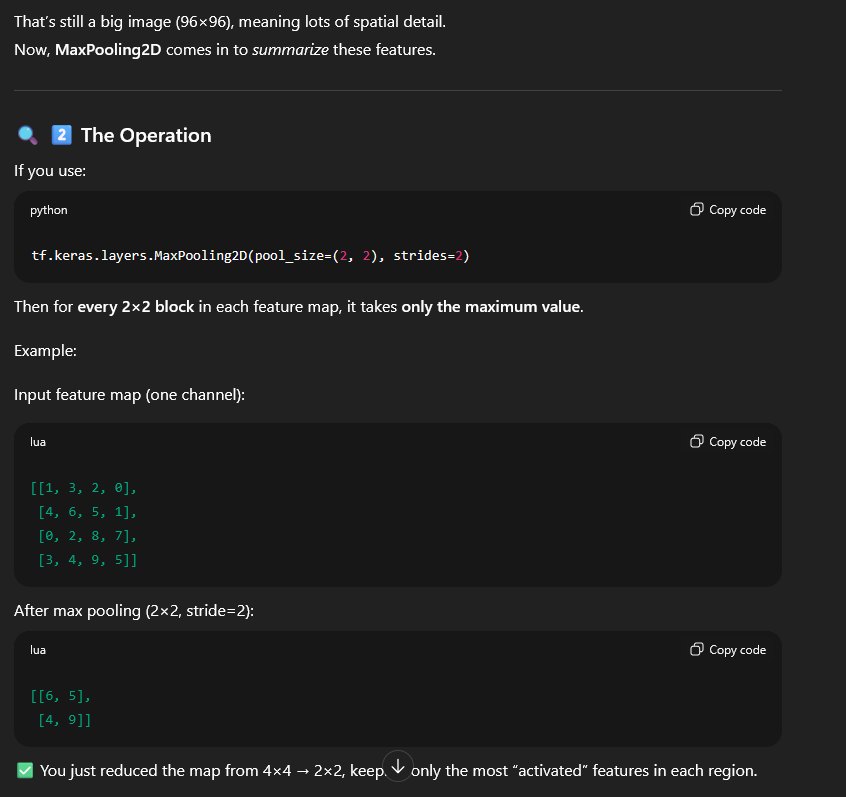

⚖️ 4️⃣ **What Happens If You Ignore Pooling**

If you remove all MaxPooling layers:

The network will retain huge feature maps (spatially large), so:

*   It consumes much more GPU memory.
*   You’ll have too many parameters when you flatten.
*   Overfitting becomes likely, since it memorizes spatial details.
*   It becomes less translation-invariant, meaning:
    *   A tumor shifted 3 pixels away might be treated as a different image.

That said, in modern CNNs, some architectures (like ResNet) replace pooling with strided convolutions, which learn how to downsample instead of hardcoding max pooling.
But the principle remains: you must reduce spatial size gradually.

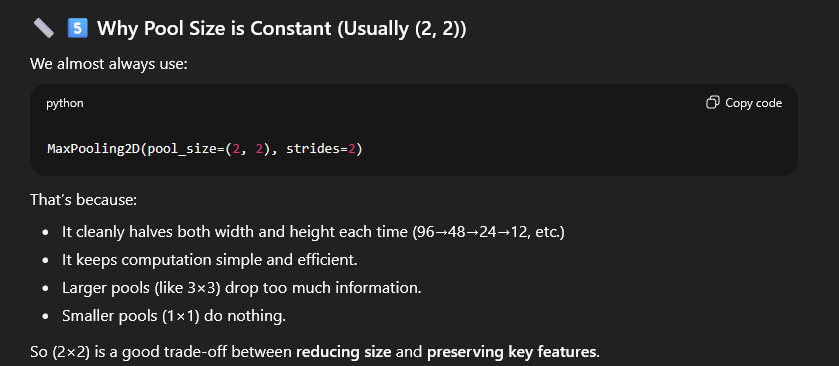

In [10]:
# Now I will create 2 models to compare between them
relu_model = build_CNN()
tanh_model = build_CNN('tanh')

relu_model.summary()
tanh_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CNN_Layer_1 (Conv2D)            │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Layer_2 (Conv2D)            │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Layer_3 (Conv2D)            │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_2 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,993 (9.39 MB)

 Trainable params: 2,460,993 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CNN_Layer_1 (Conv2D)            │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Layer_2 (Conv2D)            │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Layer_3 (Conv2D)            │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_1 (Dense)           │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_2 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,993 (9.39 MB)

 Trainable params: 2,460,993 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Training Both models
history_relu = relu_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
history_tanh = tanh_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7257 - loss: 0.5591 - val_accuracy: 0.8286 - val_loss: 0.4370
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8098 - loss: 0.4666 - val_accuracy: 0.8325 - val_loss: 0.4311
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8307 - loss: 0.4321 - val_accuracy: 0.8294 - val_loss: 0.4519
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8439 - loss: 0.4065 - val_accuracy: 0.8207 - val_loss: 0.4559
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8448 - loss: 0.3985 - val_accuracy: 0.8231 - val_loss: 0.4456
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8591 - loss: 0.3767 - val_accuracy: 0.8515 - val_loss: 0.3881
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8500 - loss: 0.3803 - val_accuracy: 0.7220 - val_loss: 0.6016
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8195 - loss: 0.4411 - val_acc

In [13]:
test_loss_relu, test_acc_relu = relu_model.evaluate(x_test, y_test)
test_loss_tanh, test_acc_tanh = tanh_model.evaluate(x_test, y_test)
print("ReLU Test Accuracy:", test_acc_relu)
print("Tanh Test Accuracy:", test_acc_tanh)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8687 - loss: 0.3388
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6716 - loss: 0.6373
ReLU Test Accuracy: 0.8672566413879395
Tanh Test Accuracy: 0.6864728331565857


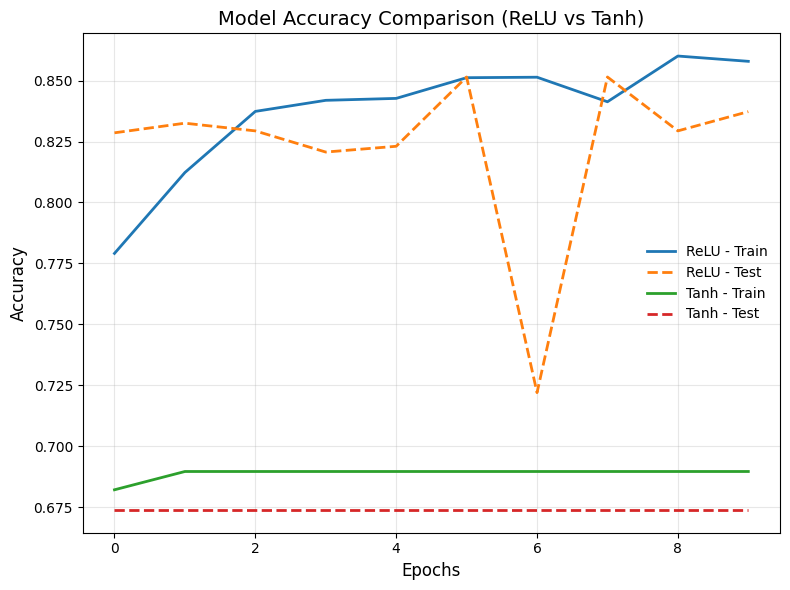

In [16]:
plt.figure(figsize=(8,6))
plt.plot(history_relu.history['accuracy'], label='ReLU - Train', linewidth=2)
plt.plot(history_relu.history['val_accuracy'], label='ReLU - Test', linestyle='--', linewidth=2)
plt.plot(history_tanh.history['accuracy'], label='Tanh - Train', linewidth=2)
plt.plot(history_tanh.history['val_accuracy'], label='Tanh - Test', linestyle='--', linewidth=2)

plt.title('Model Accuracy Comparison (ReLU vs Tanh)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
